# Image Classifier with Transfer Learning
- Classifies an image into Cat, Dog, Horse or Human 
- Uses Transfer Learning on resnet50

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.layers import *
from keras.models import Model
from keras.utils import to_categorical

## Data collection

In [2]:
# Dictionaries to interconvert classes to numeric labels and vice versa
classToNumLabel={
    'cats':0,
    'dogs':1,
    'horses':2,
    'humans':3
}

numLabelToClass={v:k for k,v in classToNumLabel.items()}

In [3]:
X=[]
y=[]
for folder in os.listdir('data'):
    folderPath='data/'+folder
    print(folderPath)
    all_images=os.listdir(folderPath)
    for img in all_images:
        img=image.load_img(os.path.join(folderPath,img),target_size=(224,224))
        img=np.array(img)
        img=preprocess_input(img)
        X.append(img)
        y.append(classToNumLabel[folder])

data/cats
data/dogs
data/horses
data/humans


## Data preprocessing

In [4]:
X=np.array(X)
y=np.array(y)

In [5]:
print(X.shape,y.shape)

(808, 224, 224, 3) (808,)


In [6]:
from sklearn.utils import shuffle

In [7]:
X,y=shuffle(X,y,random_state=42) # Shuffle the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


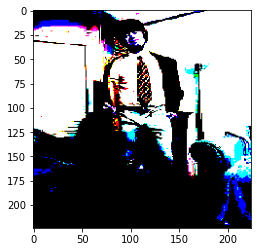

humans


In [8]:
plt.imshow(X[500])
plt.show()
print(numLabelToClass[y[500]])

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Split the data into training and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=2)

In [11]:
# Convert outputs to categorical
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

## Build the model

In [12]:
resnet=ResNet50(include_top=True,weights='imagenet')

In [13]:
x=resnet.layers[-2].output # x is the output of 2nd last layer
fc=Dense(4,activation='softmax')(x) # add Dense layer fc after x

In [14]:
my_model=Model(inputs=resnet.input,outputs=fc)

In [15]:
# Freeze all layers above fc
for l in my_model.layers[:-2]:
    l.trainable=False

In [16]:
# Compile the model
my_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
__________________________________________________________________________________________________


In [18]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
# Checkpoint - to get the best model
checkpnt=ModelCheckpoint('./best_model.h5',monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=False,mode='auto') # Whenever val_accuaracy is increased then current model is saved
# Earlystopping - to avoid unnecessary epochs
earlystop=EarlyStopping(monitor='val_accuracy',min_delta=0.005,patience=5,verbose=1,mode='auto',restore_best_weights=True) # If val_accuarcy is not improved by 0.005 for 5 epochs then it will early stop

In [19]:
# Train the model
hist=my_model.fit(X_train,y_train,batch_size=32,epochs=20,validation_split=0.1,shuffle=True,callbacks=[checkpnt,earlystop])

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.8104
Epoch 00001: val_accuracy improved from -inf to 0.95652, saving model to ./best_model.h5
20/20 [==============================] - 107s 5s/step - loss: 0.5319 - accuracy: 0.8104 - val_loss: 0.1526 - val_accuracy: 0.9565
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9789
Epoch 00002: val_accuracy improved from 0.95652 to 0.98551, saving model to ./best_model.h5
20/20 [==============================] - 108s 5s/step - loss: 0.0917 - accuracy: 0.9789 - val_loss: 0.0653 - val_accuracy: 0.9855
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9935
Epoch 00003: val_accuracy improved from 0.98551 to 1.00000, saving model to ./best_model.h5
20/20 [==============================] - 106s 5s/step - loss: 0.0466 - accuracy: 0.9935 - val_loss: 0.0447 - val_accuracy: 1.0000
Epoch 4/20
20/20 [==============================] - ETA

In [20]:
from keras.models import load_model

In [21]:
best_model=load_model('best_model.h5') # Load the best model

## Lets check the accuracy of best_model on testing data

In [22]:
best_model.evaluate(X_test,y_test)

4/4 [==============================] - 14s 3s/step - loss: 0.0551 - accuracy: 0.9836


[0.05507247895002365, 0.9836065769195557]

In [23]:
y_pred=np.argmax(best_model.predict(X_test),axis=1)
y_true=np.argmax(y_test,axis=1)

In [24]:
acc=((y_pred==y_true).sum()/y_pred.shape[0])*100
print(acc)

98.36065573770492


So we are getting very high <b> testing accuracy of 98.36</b>

## Test for external images

In [25]:
def classifyImage(path):
    img1=image.load_img(path,target_size=(224,224))
    img1=np.array(img1)
    plt.imshow(img1)
    plt.show()
    img1=preprocess_input(img1)
    pred=np.argmax(best_model.predict(img1.reshape(1,224,224,3)))
    print(numLabelToClass[pred])

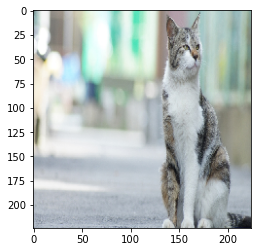

cats


In [26]:
classifyImage('externalImages/ecab8c7af42a439d9043b0ade6e1f05b_18.jpg')

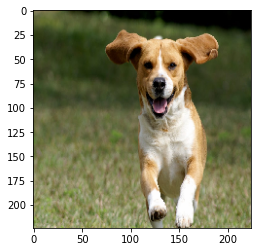

dogs


In [27]:
classifyImage('externalImages/5484d9d1eab8ea3017b17e29.jfif')

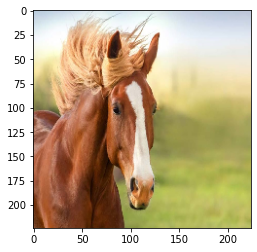

horses


In [28]:
classifyImage('externalImages/Horse-1200x900.jpg')

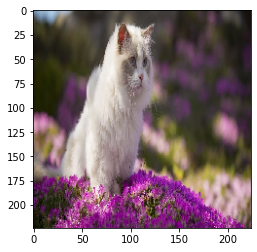

dogs


In [29]:
classifyImage('externalImages/why-cats-are-best-pets-1559241235.jpg')

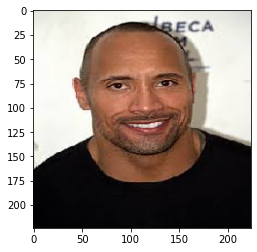

humans


In [30]:
classifyImage('externalImages/download.jfif')

## Conclusion
Note here the data is very small, even though we are able to get <b> Validation Accuracy of 98.36 </b> with Transfer learning over ResNet50. So we can use such opensource pretrained models whenever we don't have a lot of data.